Most Significant Variables Affecting Heart Disease
Introduction

Coronary heart disease is a disease in the heart and coronary arteries which is caused by the buildup of fatty materials in the blood vessels that supply oxygen. This can cause a heart attack, chest pain or angina (clotting). Main factors that affect heart disease (based on the cdc) : High blood pressure, high cholesterol and smoking are key risk factors of heart disease. However other factors also increase the risk of heart disease such as diabetes, physical inactivity, overweightness and obesity.

Hence, the question we want to answer is "Which variables from the dataset have the most significant impact on predicting heart disease?".

The dataset used will be the Cleveland Heart Disease dataset taken from the UCI repository collected in the city of Cleveland Ohio donated in 1988. It consists of 303 individual observations under 76 variables. Of the 76 variables, there were 14 main variables, of which 4 were selected to be analyzed for correlation to the likelihood of an individual to experience heart disease.
Preliminary Exploratory Data Analysis

In [1]:
library(dplyr)
library(tidyverse)
library(tidymodels)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales

In [2]:
# Read data into R
heart_disease_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)

# Modify column names 
colnames(heart_disease_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num") 

# Modify datatypes
heart_disease_data <- heart_disease_data |>
    mutate(sex = as.factor(sex)) |>
    mutate(cp = as.factor(cp)) |>
    mutate(fbs = as.factor(fbs)) |>
    mutate(restecg = as.factor(restecg)) |>
    mutate(exang = as.factor(exang)) |>
    mutate(slope = as.factor(slope)) |>
    mutate(thal = as.factor(thal)) |>
    mutate(num = as.factor(num)) |>
    mutate(ca = as.factor(ca))

# Change "?" to NA
heart_disease_data[heart_disease_data == "?"] <- NA

head(heart_disease_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [3]:
set.seed(9999) 
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = num)
heart_disease_training <- training(heart_disease_split)
heart_disease_testing <- testing(heart_disease_split)

In [4]:
selected_heart_disease_vars <- heart_disease_training |> 
    select(age, trestbps, chol, thalach, num)
head(selected_heart_disease_vars)

age,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,0
37,130,250,187,0
41,130,204,172,0
56,120,236,178,0
56,140,294,153,0
44,120,263,173,0


In [5]:
selected_heart_disease_vars |> 
    filter(is.na(age) | is.na(trestbps) | is.na(chol) | is.na(thalach)| is.na(num))

age,trestbps,chol,thalach,num
<dbl>,<dbl>,<dbl>,<dbl>,<fct>


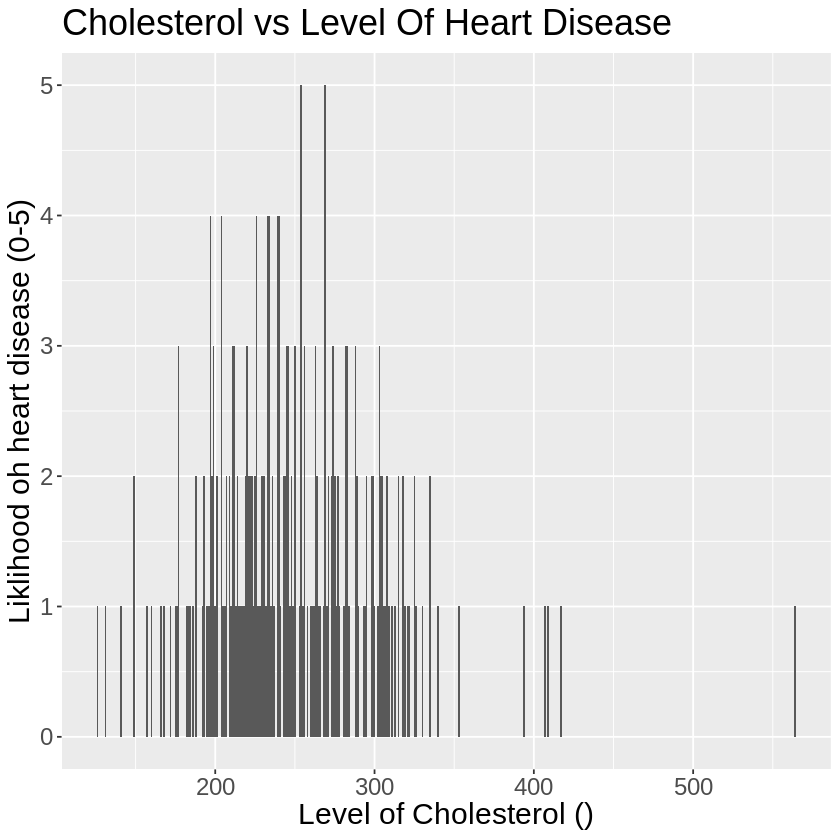

In [6]:
heart_disease_training |> 
    ggplot(aes(x = chol)) +
    geom_bar(width = 1) +
    xlab("Level of Cholesterol ()") +
    ylab("Liklihood oh heart disease (0-5)") +
    ggtitle("Cholesterol vs Level Of Heart Disease") +
    theme(text = element_text(size = 18))

Generate a KNN classification model for age:

In [12]:
# create a recipe
age_recipe <- recipe(num ~ age, data = heart_disease_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# create a KNN classification model with k unspecified
age_knn <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# perform cross validation 
age_vfold <- vfold_cv(heart_disease_training, v = 5, strata = num)

# fit the model and calculate the accuracy of each K values 
age_accuracy <- workflow() |>
    add_recipe(age_recipe) |>
    add_model(age_knn) |>
    tune_grid(resamples = age_vfold, grid = 10) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
age_accuracy

! Fold4: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4745597,5,0.029384309,Preprocessor1_Model1
2,accuracy,multiclass,0.4611210,5,0.022619061,Preprocessor1_Model2
4,accuracy,multiclass,0.4820678,5,0.032095846,Preprocessor1_Model3
6,accuracy,multiclass,0.5052311,5,0.017518982,Preprocessor1_Model4
7,accuracy,multiclass,0.5180896,5,0.012769050,Preprocessor1_Model5
9,accuracy,multiclass,0.5404354,5,0.010793463,Preprocessor1_Model6
11,accuracy,multiclass,0.5353884,5,0.009756493,Preprocessor1_Model7
13,accuracy,multiclass,0.5311331,5,0.010985779,Preprocessor1_Model8
14,accuracy,multiclass,0.5311331,5,0.010985779,Preprocessor1_Model9


Now that we have accuracies for each K value, we can plot a graph of accuracy versus neighbors

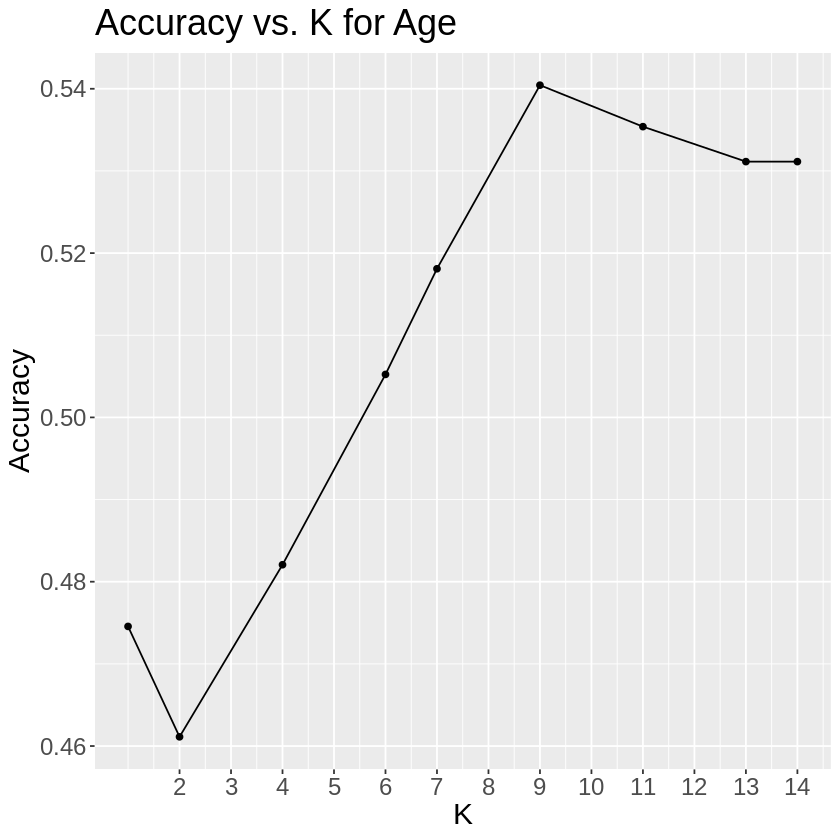

In [20]:
age_acc_plot <- age_accuracy |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "K", y = "Accuracy") +
    ggtitle("Accuracy vs. K for Age") +
    theme(text = element_text(size=18)) +
    scale_x_continuous(breaks = 2:14)
age_acc_plot              

According to this graph, the accuracy is highest when K = 9; therefore, we can specify neighbors = 9 when generating the KNN model for age. However, it should be noted that even though the accuracy is the most at K = 9, this highest accuracy value only reaches 0.54, which means the model only predicts 54% of the data correctly.

In [25]:
# generate the best KNN classification model for age, specifying K = 9
age_knn_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

# fit the training data using the best model
age_fit <- workflow() |> 
    add_recipe(age_recipe) |> 
    add_model(age_knn_best) |> 
    fit(data = heart_disease_training)

# predict the test dataset using the fit model
age_predict <- predict(age_fit, heart_disease_testing) |> 
    bind_cols(heart_disease_testing) |>
    metrics(truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy")
age_predict

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5064935
